In [1]:
# Data science imports
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import pickle

# Baseline imports
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
from nltk.tokenize import word_tokenize

def preprocess_text(raw_text):
    text = raw_text.lower().strip()
    text = re.sub('[^a-zA-Z]', ' ', text)
    word_list = word_tokenize(text)  # better tokenization
    lemm = WordNetLemmatizer()
    stops = set(stopwords.words('english')) - {'not'}
    processed_words = [lemm.lemmatize(w) for w in word_list if w not in stops]
    return ' '.join(processed_words)



In [3]:
from tensorflow.keras.layers import LSTM, GRU

def create_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(LSTM(32,dropout=0.3, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [4]:
# Visualization functions
def visualize_training(hist):
    fig, (acc_plot, loss_plot) = plt.subplots(1, 2, figsize=(12, 4))
    acc_plot.plot(hist.history['accuracy'], label='Train')
    acc_plot.plot(hist.history['val_accuracy'], label='Validation')
    acc_plot.set_title('Model Accuracy Over Time')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.set_xlabel('Epoch')
    acc_plot.legend()
    loss_plot.plot(hist.history['loss'], label='Train')
    loss_plot.plot(hist.history['val_loss'], label='Validation')
    loss_plot.set_title('Model Loss Over Time')
    loss_plot.set_ylabel('Loss')
    loss_plot.set_xlabel('Epoch')
    loss_plot.legend()
    plt.tight_layout()
    plt.show()

In [5]:
def show_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [6]:
VOCAB_SIZE = 5000
MAX_SEQ_LENGTH = 100
EMBED_SIZE = 16
BATCH_SIZE = 32
NUM_EPOCHS = 15

print("Loading restaurant review data...")
df = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t', quoting=3)

print("Preprocessing reviews...")
df['processed_text'] = df['Review'].apply(preprocess_text)


Loading restaurant review data...
Preprocessing reviews...



Performing EDA...


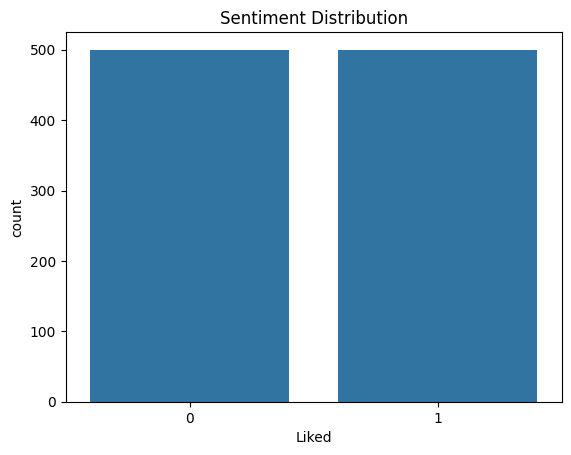

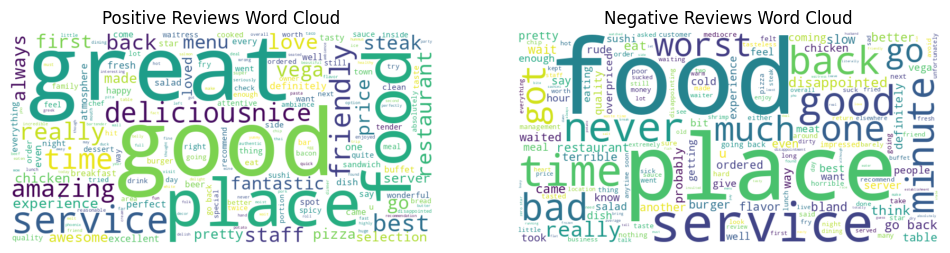


Top 10 words in negative reviews: [('not', 99), ('food', 67), ('place', 51), ('service', 40), ('back', 38), ('like', 29), ('time', 29), ('go', 26), ('good', 22), ('would', 22)]


In [7]:
print("\nPerforming EDA...")
sns.countplot(x='Liked', data=df)
plt.title("Sentiment Distribution")
plt.show()

positive_text = " ".join(df[df['Liked'] == 1]['processed_text'])
negative_text = " ".join(df[df['Liked'] == 0]['processed_text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()

neg_words = negative_text.split()
neg_common = Counter(neg_words).most_common(10)
print("\nTop 10 words in negative reviews:", neg_common)


In [8]:
print("\nTraining baseline Logistic Regression model...")
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['processed_text'])
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, df['Liked'], test_size=0.2, random_state=42
)
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train_tfidf)
baseline_acc = log_reg.score(X_test_tfidf, y_test_tfidf)
print(f"Baseline Accuracy (Logistic Regression): {baseline_acc:.2%}")



Training baseline Logistic Regression model...
Baseline Accuracy (Logistic Regression): 78.00%


In [9]:
print("Tokenizing text...")
tok = Tokenizer(num_words=VOCAB_SIZE)
tok.fit_on_texts(df['processed_text'])
sequences = tok.texts_to_sequences(df['processed_text'])
X = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)
y = df['Liked'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Tokenizing text...


Creating LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training model...
Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5470 - loss: 0.6928 - val_accuracy: 0.4563 - val_loss: 0.6949
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5438 - loss: 0.6901 - val_accuracy: 0.4563 - val_loss: 0.6946
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5401 - loss: 0.6908 - val_accuracy: 0.4875 - val_loss: 0.6907
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5651 - loss: 0.6866 - val_accuracy: 0.5188 - val_loss: 0.6862
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6771 - loss: 0.6710 - val_accuracy: 0.7688 - val_loss: 0.6651
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8084 - loss: 0.6232 - val_accuracy: 0.8062 - val_loss: 0.6002
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8360 - loss: 0.5050 - val_accuracy: 0.7500 - val_loss: 0.5249
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9040 - loss: 0.3030 - val_ac

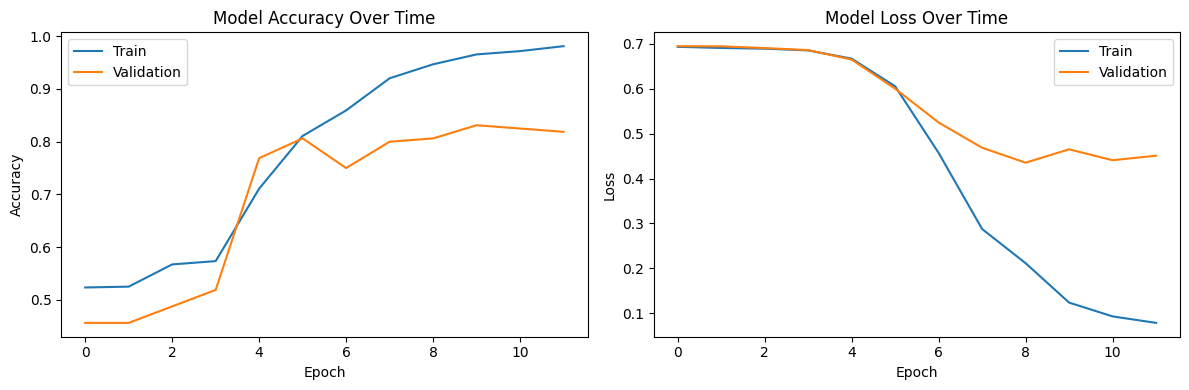

In [10]:
print("Creating LSTM model...")
sentiment_model = create_lstm_model(VOCAB_SIZE, EMBED_SIZE, MAX_SEQ_LENGTH)


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Training model...")
training_history = sentiment_model.fit(
    X_train,
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping]
)

visualize_training(training_history)



Evaluating model performance...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Test Accuracy: 77.50%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        96
           1       0.80      0.75      0.78       104

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.78       200



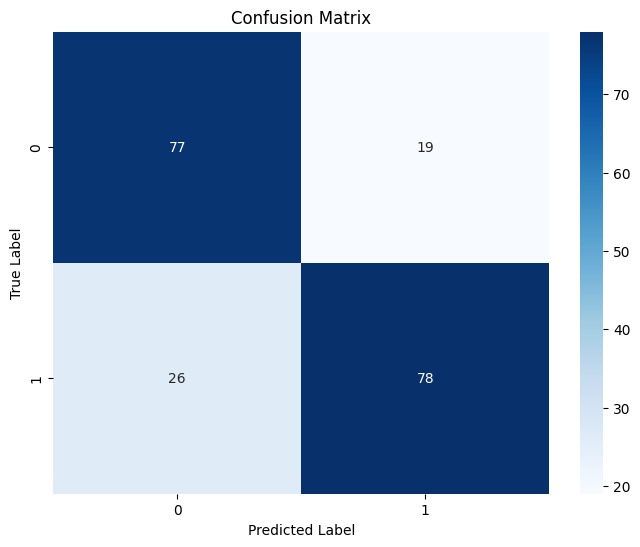

In [11]:
print("\nEvaluating model performance...")
y_pred = (sentiment_model.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.2%}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
show_confusion_matrix(conf_mat)



In [12]:
sentiment_model.save("restaurant_sentiment_model.h5")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tok, f)
print("\nModel and tokenizer saved for deployment.")



Model and tokenizer saved for deployment.


In [13]:
def predict_sentiment(review):
    clean = preprocess_text(review)
    seq = tok.texts_to_sequences([clean])
    padded = pad_sequences(seq, maxlen=MAX_SEQ_LENGTH)
    prediction = sentiment_model.predict(padded)[0][0]
    confidence = prediction if prediction > 0.5 else (1 - prediction)
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return f"{sentiment} ({confidence:.1%} confident)"

review = input("\nEnter Your review here: ")
sentiment = predict_sentiment(review)
print(f"Review: {review}")
print(f"Sentiment: {sentiment}\n")



Enter Your review here: The food was awesome
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Review: The food was awesome
Sentiment: Positive (85.5% confident)



In [14]:

# Compute accuracy values
baseline_acc_percent = baseline_acc * 100   # baseline_acc comes from log_reg.score()
lstm_acc_percent = accuracy_score(y_test, y_pred) * 100   # y_pred comes from LSTM predictions


In [15]:
print("📊 Business Insights Summary:\n")
print(f"1️⃣ Baseline Logistic Regression achieved {baseline_acc_percent:.2f}% accuracy, "
      f"while the LSTM improved this to {lstm_acc_percent:.2f}%.\n")

print("2️⃣ Top recurring complaints in negative reviews:")
for word, count in neg_common:
    print(f"   - {word} ({count} mentions)")

print("\n3️⃣ Impact Insight:")
if lstm_acc_percent > baseline_acc_percent:
    print("   The LSTM model can detect negative sentiment more effectively, "
          "even when issues are not explicitly mentioned, helping prioritize customer follow-up.")
else:
    print("   The baseline model performed similarly, suggesting simpler models could be deployed cost-effectively.")

print("\n4️⃣ Recommendation:")
print("   Use these sentiment predictions to automatically flag negative reviews for timely customer service actions, "
      "targeting complaints about service, food, or wait times. This can improve customer satisfaction and retention.")


📊 Business Insights Summary:

1️⃣ Baseline Logistic Regression achieved 78.00% accuracy, while the LSTM improved this to 77.50%.

2️⃣ Top recurring complaints in negative reviews:
   - not (99 mentions)
   - food (67 mentions)
   - place (51 mentions)
   - service (40 mentions)
   - back (38 mentions)
   - like (29 mentions)
   - time (29 mentions)
   - go (26 mentions)
   - good (22 mentions)
   - would (22 mentions)

3️⃣ Impact Insight:
   The baseline model performed similarly, suggesting simpler models could be deployed cost-effectively.

4️⃣ Recommendation:
   Use these sentiment predictions to automatically flag negative reviews for timely customer service actions, targeting complaints about service, food, or wait times. This can improve customer satisfaction and retention.
